<a href="https://colab.research.google.com/github/amitav710/SAiDL-Spring-Assignment-2022/blob/main/SRResNet_subpixel1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math
import os
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from keras.models import Sequential
from keras.layers import Conv2D, ReLU, BatchNormalization, Add
from keras import layers
from tensorflow.keras.optimizers import Adam
import cv2
from google.colab.patches import cv2_imshow
import pandas as pd
import PIL
import PIL.Image
import pathlib
from tensorflow.keras.utils import plot_model

In [2]:
ds_train, info_train = tfds.load('oxford_iiit_pet', split='train', with_info=True, shuffle_files=False, as_supervised=True)
df_train = tfds.as_dataframe(ds_train.take(5), info_train)
df_train.head()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteDCQNOJ/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteDCQNOJ/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


,image,label
0,"[[[3, 3, 3], [5, 3, 4], [7, 5, 6], [4, 2, 3], ...",33
1,"[[[5, 9, 8], [3, 4, 0], [11, 24, 4], [36, 51, ...",12
2,"[[[44, 32, 6], [44, 34, 7], [44, 34, 7], [41, ...",9
3,"[[[108, 130, 117], [114, 133, 127], [108, 128,...",32
4,"[[[237, 228, 91], [236, 228, 93], [230, 225, 8...",33


In [3]:
x_train=[]
for data in ds_train:
  x,_ = data
  x=x.numpy()
  x=cv2.resize(x, (300,300))
  x_train.append(x)
x_train = np.array(x_train)
x_train.shape

(3680, 300, 300, 3)

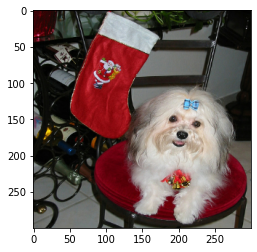

In [4]:
plt.imshow(x_train[77])

# Converting into Low-Res Image by Downscaling and Blurring

In [12]:
!pip install tensorflow_addons==0.15

     |████████████████████████████████| 1.1 MB 7.5 MB/s 


In [13]:
import tensorflow_addons as tfa

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [5]:
def lowres(img:np.ndarray): #dealing with 0 to 1 float values after conversion
  img=tfa.image.gaussian_filter2d(img, filter_shape=(3,3))
  new=tf.image.resize(img, (100,100), method=tf.image.ResizeMethod.AREA, preserve_aspect_ratio=False, antialias=False)
  return new/255

In [8]:
inputs=[]
for i in x_train:
  a=lowres(i)
  inputs.append(a)
inputs=np.array(inputs)

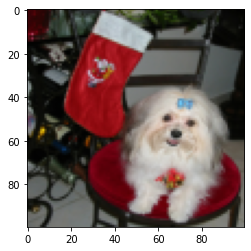

In [9]:
plt.imshow(inputs[77])

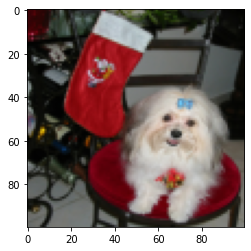

In [10]:
plt.imshow(lowres(x_train[77]))

# Loading our Weights

In [11]:
!pwd

/content


In [6]:
pb_model = "./subpixel_wts"
# Loading the Tensorflow Saved Model (PB)
SRResNet = tf.keras.models.load_model(pb_model)
print(SRResNet.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 100, 100, 64  4864        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_8 (Conv2D)              (None, 100, 100, 64  102464      ['conv2d_7[0][0]']               
                                )                                                           

# Building our ResNet model


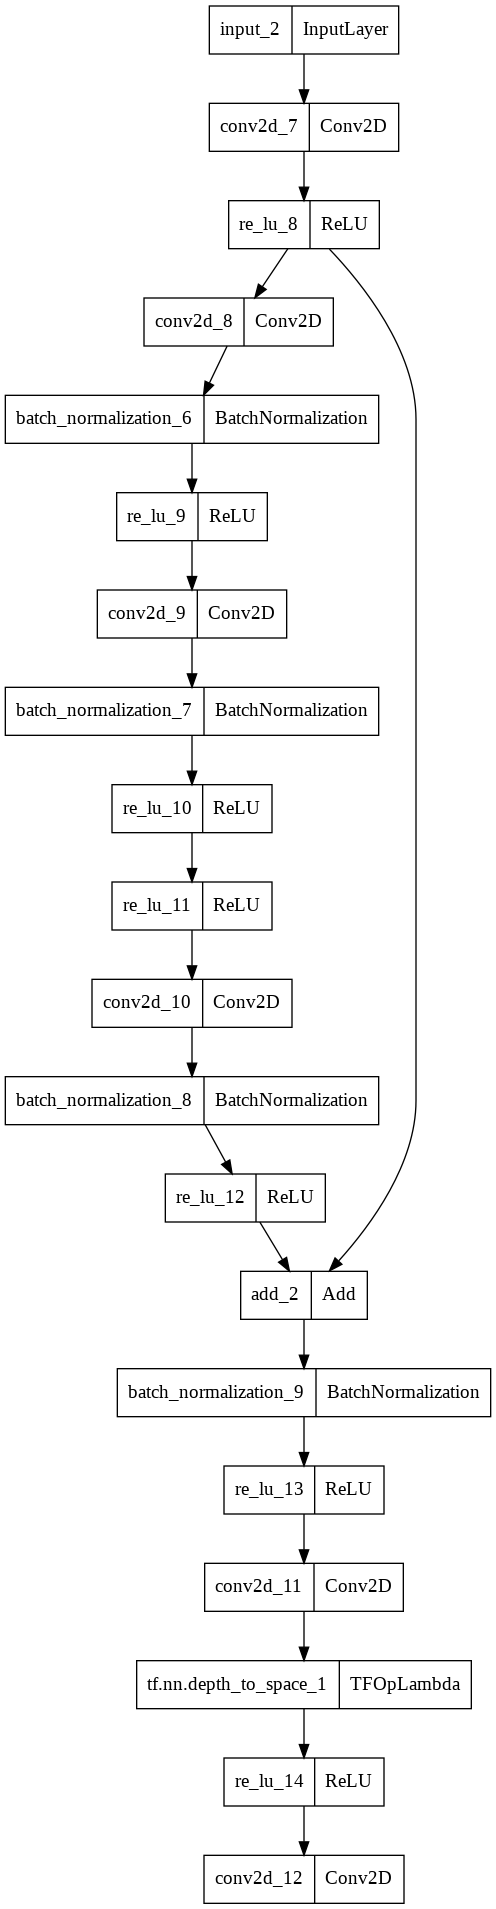

In [3]:
shape=(100,100,3)
input=layers.Input(shape)

x = (Conv2D(filters=64, kernel_size = (5, 5), kernel_initializer='glorot_uniform', activation='relu', padding='same', use_bias=True, input_shape=(100, 100, 3)))(input)
x = (ReLU())(x)
xcopy1=x
xcopy2=x
xcopy3=x
x1 = (Conv2D(filters=64, kernel_size = (5, 5), kernel_initializer='glorot_uniform', activation='relu', padding='same'))(xcopy1)
x1 = BatchNormalization(momentum=0.02)(x1)
x1 = (ReLU())(x1)
x1 = (Conv2D(filters=64, kernel_size = (5, 5), kernel_initializer='glorot_uniform', activation='relu', padding='same'))(x1)
x1 = BatchNormalization(momentum=0.02)(x1)
x1 = (ReLU())(x1)

x2 = (ReLU())(x1)
x2 = (Conv2D(filters=64, kernel_size = (5, 5), kernel_initializer='glorot_uniform', activation='relu', padding='same'))(x2)
x2 = BatchNormalization(momentum=0.02)(x2)
x2 = (ReLU())(x2)

x=Add()([xcopy3,x2])
x = (BatchNormalization(momentum=0.02))(x)
x = (ReLU())(x)

x=(Conv2D(filters=27, kernel_size = (3, 3), kernel_initializer='glorot_uniform', activation="relu", padding= "same"))(x)
x=tf.nn.depth_to_space(x, 3) #our upscale factor
x = (ReLU())(x)

x= (Conv2D(filters=3, kernel_size = (3, 3), kernel_initializer='glorot_uniform', activation='linear', padding='same', use_bias=True))(x)

SRResNet = tf.keras.Model(inputs=input, outputs=x)
plot_model(SRResNet)

In [13]:
adam = Adam(learning_rate=0.0001)

In [14]:
SRResNet.compile(optimizer= adam, loss='mean_squared_error', metrics=['mean_squared_error'], run_eagerly=True)

In [15]:
early_stop=keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=10, mode='min', restore_best_weights=True)

In [16]:
model_save_location='subpixel_wts'

In [17]:
checkpoint=keras.callbacks.ModelCheckpoint(model_save_location, monitor='mean_squared_error', save_best_only=True, mode='min')

In [4]:
SRResNet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 100, 100, 64  4864        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 re_lu_8 (ReLU)                 (None, 100, 100, 64  0           ['conv2d_7[0][0]']               
                                )                                                           

In [40]:
history=SRResNet.fit(x=inputs, y=x_train, epochs=25, batch_size=32, callbacks=[early_stop, checkpoint])

Epoch 1/25
115/115 [==============================] - ETA: 0s - loss: 164.6857 - mean_squared_error: 164.6857INFO:tensorflow:Assets written to: subpixel_wts/assets


INFO:tensorflow:Assets written to: subpixel_wts/assets


115/115 [==============================] - 47s 409ms/step - loss: 164.6857 - mean_squared_error: 164.6857
Epoch 2/25
115/115 [==============================] - 44s 383ms/step - loss: 164.8107 - mean_squared_error: 164.8107
Epoch 3/25
115/115 [==============================] - 44s 383ms/step - loss: 164.9215 - mean_squared_error: 164.9215
Epoch 4/25
115/115 [==============================] - ETA: 0s - loss: 161.2813 - mean_squared_error: 161.2813INFO:tensorflow:Assets written to: subpixel_wts/assets


INFO:tensorflow:Assets written to: subpixel_wts/assets


115/115 [==============================] - 47s 405ms/step - loss: 161.2813 - mean_squared_error: 161.2813
Epoch 5/25
115/115 [==============================] - ETA: 0s - loss: 160.5740 - mean_squared_error: 160.5740INFO:tensorflow:Assets written to: subpixel_wts/assets


INFO:tensorflow:Assets written to: subpixel_wts/assets


115/115 [==============================] - 47s 406ms/step - loss: 160.5740 - mean_squared_error: 160.5740
Epoch 6/25
115/115 [==============================] - ETA: 0s - loss: 159.6389 - mean_squared_error: 159.6389INFO:tensorflow:Assets written to: subpixel_wts/assets


INFO:tensorflow:Assets written to: subpixel_wts/assets


115/115 [==============================] - 47s 410ms/step - loss: 159.6389 - mean_squared_error: 159.6389
Epoch 7/25
115/115 [==============================] - ETA: 0s - loss: 157.9238 - mean_squared_error: 157.9238INFO:tensorflow:Assets written to: subpixel_wts/assets


INFO:tensorflow:Assets written to: subpixel_wts/assets


115/115 [==============================] - 47s 405ms/step - loss: 157.9238 - mean_squared_error: 157.9238
Epoch 8/25
115/115 [==============================] - 44s 383ms/step - loss: 160.4747 - mean_squared_error: 160.4747
Epoch 9/25
115/115 [==============================] - ETA: 0s - loss: 156.0837 - mean_squared_error: 156.0837INFO:tensorflow:Assets written to: subpixel_wts/assets


INFO:tensorflow:Assets written to: subpixel_wts/assets


115/115 [==============================] - 47s 405ms/step - loss: 156.0837 - mean_squared_error: 156.0837
Epoch 10/25
115/115 [==============================] - 44s 383ms/step - loss: 159.5445 - mean_squared_error: 159.5444
Epoch 11/25
115/115 [==============================] - ETA: 0s - loss: 155.6582 - mean_squared_error: 155.6581INFO:tensorflow:Assets written to: subpixel_wts/assets


INFO:tensorflow:Assets written to: subpixel_wts/assets


115/115 [==============================] - 47s 409ms/step - loss: 155.6582 - mean_squared_error: 155.6581
Epoch 12/25
115/115 [==============================] - 44s 382ms/step - loss: 158.7955 - mean_squared_error: 158.7955
Epoch 13/25
115/115 [==============================] - 44s 383ms/step - loss: 157.2733 - mean_squared_error: 157.2734
Epoch 14/25
115/115 [==============================] - 44s 383ms/step - loss: 157.3133 - mean_squared_error: 157.3133
Epoch 15/25
115/115 [==============================] - ETA: 0s - loss: 154.2862 - mean_squared_error: 154.2862INFO:tensorflow:Assets written to: subpixel_wts/assets


INFO:tensorflow:Assets written to: subpixel_wts/assets


115/115 [==============================] - 47s 406ms/step - loss: 154.2862 - mean_squared_error: 154.2862
Epoch 16/25
115/115 [==============================] - 44s 383ms/step - loss: 155.0203 - mean_squared_error: 155.0202
Epoch 17/25
115/115 [==============================] - ETA: 0s - loss: 153.8616 - mean_squared_error: 153.8616INFO:tensorflow:Assets written to: subpixel_wts/assets


INFO:tensorflow:Assets written to: subpixel_wts/assets


115/115 [==============================] - 47s 406ms/step - loss: 153.8616 - mean_squared_error: 153.8616
Epoch 18/25
115/115 [==============================] - 44s 383ms/step - loss: 155.4102 - mean_squared_error: 155.4102
Epoch 19/25
115/115 [==============================] - ETA: 0s - loss: 153.7259 - mean_squared_error: 153.7259INFO:tensorflow:Assets written to: subpixel_wts/assets


INFO:tensorflow:Assets written to: subpixel_wts/assets


115/115 [==============================] - 47s 409ms/step - loss: 153.7259 - mean_squared_error: 153.7259
Epoch 20/25
115/115 [==============================] - 44s 383ms/step - loss: 153.9806 - mean_squared_error: 153.9806
Epoch 21/25
115/115 [==============================] - 44s 383ms/step - loss: 154.8030 - mean_squared_error: 154.8030
Epoch 22/25
115/115 [==============================] - 44s 383ms/step - loss: 154.6828 - mean_squared_error: 154.6829
Epoch 23/25
115/115 [==============================] - 44s 383ms/step - loss: 154.6433 - mean_squared_error: 154.6432
Epoch 24/25
115/115 [==============================] - 44s 383ms/step - loss: 153.9967 - mean_squared_error: 153.9968
Epoch 25/25
115/115 [==============================] - ETA: 0s - loss: 152.6524 - mean_squared_error: 152.6525INFO:tensorflow:Assets written to: subpixel_wts/assets


INFO:tensorflow:Assets written to: subpixel_wts/assets


115/115 [==============================] - 47s 406ms/step - loss: 152.6524 - mean_squared_error: 152.6525


In [ ]:
ds_test, info_test = tfds.load('oxford_iiit_pet', split='test', with_info=True, shuffle_files=False, as_supervised=True)
df_test = tfds.as_dataframe(ds_test.take(5), info_test)
df_test.head()

In [9]:
x_test=[]
for data in ds_test:
  x,_ = data
  x=x.numpy()
  x=cv2.resize(x, (300,300))
  x_test.append(x)
x_test = np.array(x_test)
x_test.shape

(3669, 300, 300, 3)

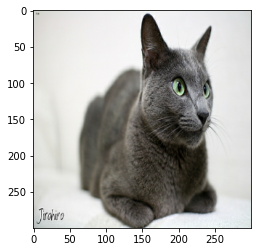

In [10]:
plt.imshow(x_test[100])

In [14]:
out=SRResNet.predict(np.expand_dims(lowres(x_test[100]), axis=0))

In [15]:
out=out/255

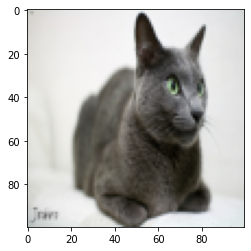

In [16]:
plt.imshow(lowres(x_test[100]))

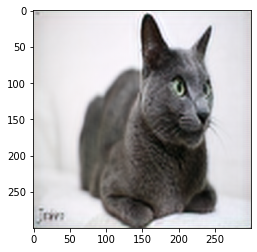

In [17]:
plt.imshow(out[0])

In [18]:
tf.image.psnr(out[0], x_test[100], 1.0)

<tf.Tensor: shape=(), dtype=float32, numpy=28.322552>

In [19]:
x100=lowres(x_test[100])

In [20]:
x100 = tf.image.resize(x100, (300,300), method=tf.image.ResizeMethod.AREA, preserve_aspect_ratio=False, antialias=False)

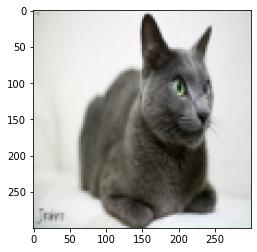

In [21]:
plt.imshow(x100)

In [22]:
tf.image.psnr(x100, x_test[100], 1.0)

<tf.Tensor: shape=(), dtype=float32, numpy=26.752045>